# Лабораторная работы №1
## Исследование свойств свертки цифровых сигналов.
***

### 1. Подключение библиотек.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### 2. Получение реальной ЭКГ.

In [2]:
from scipy.misc import electrocardiogram
ECG = electrocardiogram()

### 3. Создание объектов необходимых сигналов.

In [3]:
from abc import ABC, abstractmethod


class Signal(ABC):
    
    def __init__(self, y):
        self.x1 = np.arange(y.size)
        self.y1 = y
    
    def print_(self, title='Signal'):
        fig, ax = plt.subplots(figsize=(8, 5))
        
        ax.plot(self.x1, self.y1)

        ax.set_title(title, size=20)
        ax.set_xlabel('Samples')
        ax.set_ylabel('Amplitude')

        plt.show()
    
    
class Ecg(Signal):
    
    def __init__(self, cycles=1):
        self.cycles = cycles
        
        freq = 360
        n_start = int(12.8 * freq)
        n_finish = int(13.32 * freq)
        n = cycle = ECG[n_start:n_finish]
        for _ in range(self.cycles - 1):
            n = np.concatenate((cycle, n))

        self.x1 = np.arange(n.size)
        self.y1 = n
        
    def print_(self):
        fig, ax = plt.subplots(figsize=(8, 5))

        ax.plot(self.x1, self.y1)

        ax.set_title('Cardiogram', size=20)
        ax.set_xlabel('Samples')
        ax.set_ylabel('ECG in mV')

        plt.show()
        
    def size(self):
        return self.x1.size
        
        
class WhiteNoise(Signal):
    
    def __init__(self, deviation, size):
        self.x1 = np.arange(size)
        self.y1 = np.random.normal(0, deviation, self.x1.size)
    
    def print_(self):
        super().print_("White Noise")
        
    
class HarmNoise(Signal):
    
    def __init__(self, a_hn, f_d, f_hn, n_sin):
        td = 1/f_d
        t = np.linspace(0, td, int((n_sin - 1) * td))

        self.x1 = t
        self.y1 = [np.sin(2*np.pi*f_hn*tmp)*a_hn for tmp in t]
        
    def print_(self):
        super().print_("Harm Noise")
        

class SumSignal(Signal):
    
    def __init__(self, *signals):            
        size = signals[0].x1.size
        
        self.x1 = np.arange(size)
        self.y1 = np.zeros(size)
        
        for i in range(size):
            for sig in signals:
                self.y1[i] = self.y1[i] + sig.y1[i]
    
    def print_(self):
        super().print_("Summed signal")
                

class HSignal(Signal):
    
    def __init__(self, f_d=4, f_s=1, f_x=1, size=10):
        
        fc = (f_s + f_x)/(2 * f_d)
        W = np.zeros(size)    # Весовая функция Блекмена
        H = np.zeros(size)    # Импульсная характеристика фильтра
        h_id = np.zeros(size) # Идеальная импульсная характеристика
        
        for i in range(size):
            if i == 0:
                h_id[i] = 2 * np.pi * fc
            else:
                h_id[i] = np.sin(2 * np.pi * i)/(np.pi * i)
                
            # весовая функция Блекмена
            W[i] = 0.42 - 0.5 * np.cos((2 * np.pi * i)/(size - 1)) \
                    + 0.08 * np.cos((4 * np.pi * i)/(size - 1))
            H[i] = h_id[i] * W[i]
            
        # Нормировка импульсной характеристики
        sum_ = 0
        for i in range(H.size):
            sum_ += H[i]
        for i in range(H.size):
            H[i] /= sum_
        
        self.x1 = np.arange(size, dtype=int)
        self.y1 = H
        
    def print_(self):
        super().print_("Impulse response ")
        
    def get_values(self):
        return self.y1

class Delta(Signal):
    def __init__(self, n, length=5):
        if length < n:
            length = n + 1 
        self.x1 = np.arange(length)                   
        self.y1 = np.zeros(length)
        self.y1[n] = 1
    
    def print_(self):
        fig, ax = plt.subplots(figsize=(8, 5))

        ax.scatter(self.x1, self.y1)

        ax.set_title('Delta-function', size=20)
        ax.set_xlabel('Samples')
        ax.set_ylabel('Amplitude')

        plt.show()
        
    
class Convolution(Signal):
    
    def __init__(self, h):
        self.h = h
    
    def signals_convolution(self, sig):
        sig_size = sig.x1.size
        h_size = self.h.x1.size
        y = np.zeros(sig_size + h_size - 1)
        x = sig.y1

        for i in range(sig_size - 1):
            for j in range(h_size):
                y[i + j] += self.h.y1[j] * x[i]
        # y = y[h_size:sig_size - h_size]        
        return Signal(y)


class AveragingFilter(Signal):
    def __init__(self, n):
        self.samples = n
    
    def filter_(self, sig):
        sig_size = sig.x1.size
        samp = self.samples
        y = np.zeros(sig_size)
        x = sig.y1
        print('y.size -',y.size)

        for i in range(samp//2 - 1, sig_size - samp//2):
            for j in range(-samp//2, samp//2):
                y[i] = y[i] + x[i + j]
                print('i + j =', i + j)
            y[i] = y[i] / samp
        return Signal(y)

### 4. Создание экземпляров классов данных сигналов.

In [4]:
ecg = Ecg(cycles=1)
white_noise = WhiteNoise(deviation=0.1, size=ecg.size())
harm_noise = HarmNoise(a_hn=0.05, f_d=5, f_hn=60, n_sin=1888)
h = HSignal()
d = Delta(50)

sum_signal = SumSignal(ecg, white_noise, harm_noise)

### 5. Построение графиков сигналов.

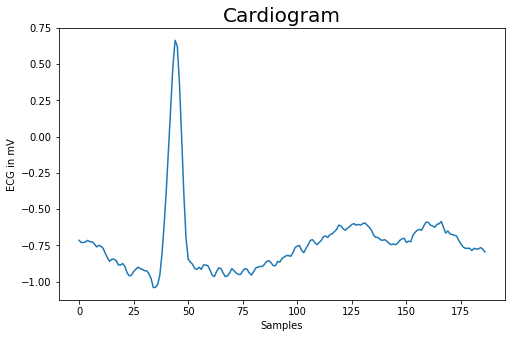

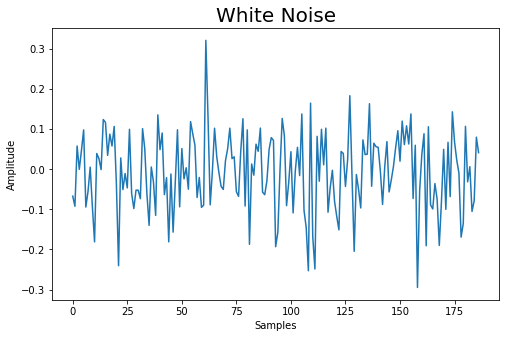

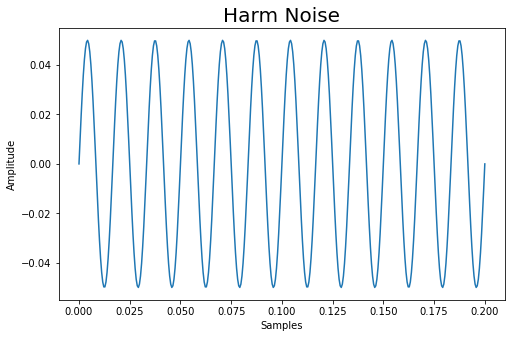

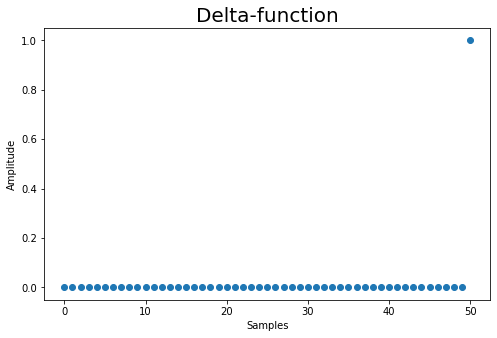

In [5]:
for signal in [ecg, white_noise, harm_noise, d]:
    signal.print_()

### 6. Свертка с h[n] и построение графиков результирующих сигналов.

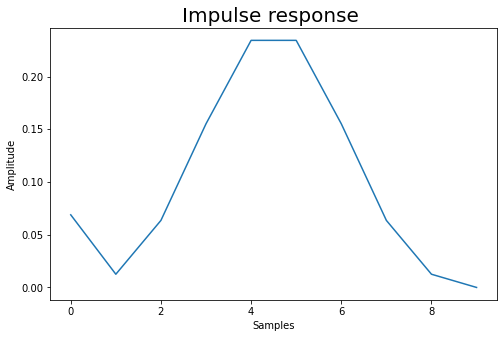

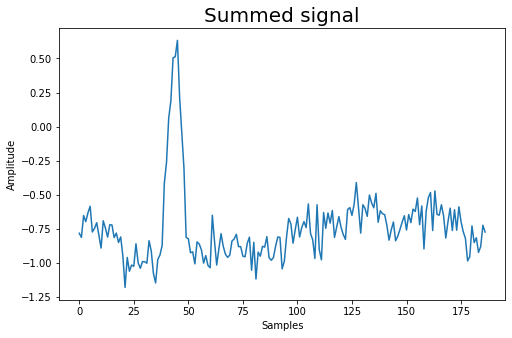

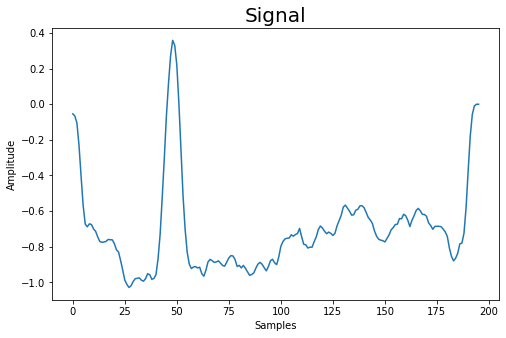

In [6]:
res = Convolution(h).signals_convolution(sum_signal)
for signal in [h, sum_signal,  res]:
    signal.print_()

### 7. Свертка ЭКГ-сигнала и Дельта-функции, смещенной на N отсчетов

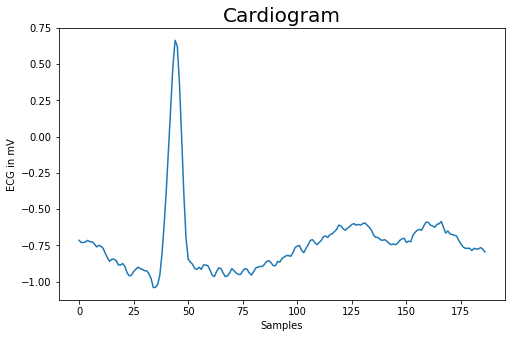

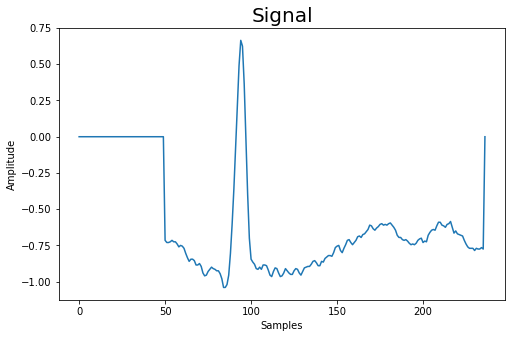

In [7]:
res_delta = Convolution(d).signals_convolution(ecg)
ecg.print_()
res_delta.print_()

### 8. Применение скользящего усредняющего фильтра 

y.size - 187
i + j = -1
i + j = 0
i + j = 1
i + j = 2
i + j = 3
i + j = 4
i + j = 0
i + j = 1
i + j = 2
i + j = 3
i + j = 4
i + j = 5
i + j = 1
i + j = 2
i + j = 3
i + j = 4
i + j = 5
i + j = 6
i + j = 2
i + j = 3
i + j = 4
i + j = 5
i + j = 6
i + j = 7
i + j = 3
i + j = 4
i + j = 5
i + j = 6
i + j = 7
i + j = 8
i + j = 4
i + j = 5
i + j = 6
i + j = 7
i + j = 8
i + j = 9
i + j = 5
i + j = 6
i + j = 7
i + j = 8
i + j = 9
i + j = 10
i + j = 6
i + j = 7
i + j = 8
i + j = 9
i + j = 10
i + j = 11
i + j = 7
i + j = 8
i + j = 9
i + j = 10
i + j = 11
i + j = 12
i + j = 8
i + j = 9
i + j = 10
i + j = 11
i + j = 12
i + j = 13
i + j = 9
i + j = 10
i + j = 11
i + j = 12
i + j = 13
i + j = 14
i + j = 10
i + j = 11
i + j = 12
i + j = 13
i + j = 14
i + j = 15
i + j = 11
i + j = 12
i + j = 13
i + j = 14
i + j = 15
i + j = 16
i + j = 12
i + j = 13
i + j = 14
i + j = 15
i + j = 16
i + j = 17
i + j = 13
i + j = 14
i + j = 15
i + j = 16
i + j = 17
i + j = 18
i + j = 14
i + j = 15
i + j = 16
i + j = 17
i +

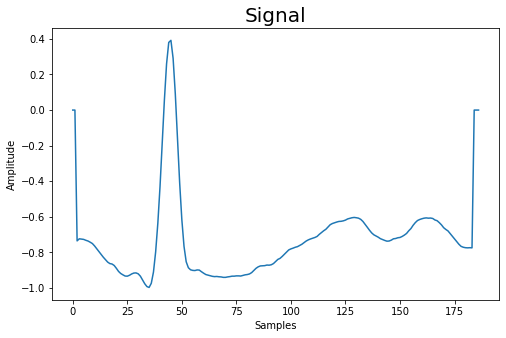

In [8]:
avg_filter = AveragingFilter(6)
res_f = avg_filter.filter_(ecg)
print(res_f.y1)
res_f.print_()

***
### Вывод: Изучили на практике процесс свертки. Научились применять его для очистки сигнала от помех.  